# Ordinal Cluster Arrangement
C. Heiser, 2019

---
__The purpose of this notebook is to prototype methods for determining ordinal arrangement of substructures within single-cell data.__  
  
To benchmark these techniques, we are using two single-cell RNAseq datasets:
* From [__Macosko, *et al* (2015)__](https://www.ncbi.nlm.nih.gov/pubmed/26000488), the mouse retina scRNA-seq data generated using DropSeq: [GSM1626793](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1626793)
* From [__Herring, *et al* (2018)__](https://www.ncbi.nlm.nih.gov/pubmed/29153838), the WT mouse retina scRNA-seq data generated using inDrops: [GSM2743164](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2743164)  
  
The first set should be __discrete__, containing highly separable cell populations from the mouse retina, where the latter will be __continuous__, representing a continuum of branching cell states in the gut epithelium.  
  
Both datasets have been __preprocessed and feature-selected__ to allow for direct input to downstream dimensionality reduction algorithms (rather than first performing PCA to limit dimensional input). These methods are shown in [`dev/QC.ipynb`](dev/QC.ipynb).

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *
%matplotlib inline

In [2]:
from functools import reduce

In [ ]:
# reload functions when editing file
del sys.modules['fcc_utils']
from fcc_utils import *

---
First, read in retina and retina datasets with all genes present

In [3]:
# read in retina data
retina = sc.read_text('../inputs/GSM1626793_P14Retina_1.processed.tsv', delimiter='\t', first_column_names=True)

In [4]:
# look at dimensions of counts matrix (cells, genes)
retina

AnnData object with n_obs × n_vars = 1326 × 500 

In [5]:
# get useful metrics of counts data
retina.var['mito'] = retina.var_names.str.contains('mt-')
sc.pp.calculate_qc_metrics(retina, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
retina.layers['raw_counts'] = retina.X.copy() # save raw counts in layer
sc.pp.normalize_total(retina, target_sum=1, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(retina, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']

# see resulting AnnData contents
retina

AnnData object with n_obs × n_vars = 1326 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

In [6]:
retina.X = retina.layers['arcsinh_norm'].copy()
sc.tl.pca(retina, use_highly_variable=False, n_comps=100)

In [7]:
retina_clu = pd.read_csv('archive/pymethods_out/retina_clu.csv', header=None)
retina.obs['cluster_fcc'] = retina_clu[0].values

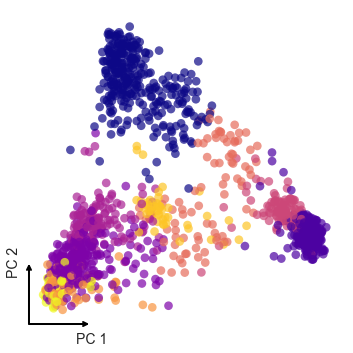

In [8]:
DR_plot(dim_name='PC', figsize=(5,5)).plot_IDs(retina, use_rep='X_pca', obs_col='cluster_fcc')

In [9]:
retina_umap = pd.read_csv('archive/pymethods_out/retina_UMAP.csv', header=None)
retina.obsm['X_umap'] = np.ascontiguousarray(retina_umap)

In [10]:
retina_tsne = pd.read_csv('archive/pymethods_out/retina_tSNE.csv', header=None)
retina.obsm['X_tsne'] = np.ascontiguousarray(retina_tsne)

In [11]:
retina_dca = pd.read_csv('archive/pymethods_out/retina_DCA.csv', header=None)
retina.obsm['X_dca'] = np.ascontiguousarray(retina_dca)

In [12]:
retina_FItsne = pd.read_csv('archive/pymethods_out/retina_FItSNE.csv', header=None)
retina.obsm['X_FItsne'] = np.ascontiguousarray(retina_FItsne)

In [13]:
retina_scVI = pd.read_csv('archive/pymethods_out/retina_scVI.csv', header=None)
retina.obsm['X_scVI'] = np.ascontiguousarray(retina_scVI)

In [14]:
retina_zifa = pd.read_csv('archive/pymethods_out/retina_ZIFA.csv', header=None)
retina.obsm['X_zifa'] = np.ascontiguousarray(retina_zifa)

In [15]:
retina_GLMPCA = pd.read_csv('archive/Rmethods_out/retina_GLM-PCA.csv', header=0)
retina.obsm['X_GLM-PCA'] = np.ascontiguousarray(retina_GLMPCA)

In [16]:
retina_SIMLR = pd.read_csv('archive/Rmethods_out/retina_SIMLR_F.csv', header=0)
retina.obsm['X_SIMLR'] = np.ascontiguousarray(retina_SIMLR)

In [17]:
retina_ZINBWAVE = pd.read_csv('archive/Rmethods_out/retina_ZINB-WAVE.csv', header=0)
retina.obsm['X_ZINBWAVE'] = np.ascontiguousarray(retina_ZINBWAVE)

In [18]:
retina_scvis = pd.read_csv('archive/scvis_out/retina/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv', sep='\t', header=0, index_col=0)
retina.obsm['X_scvis'] = np.ascontiguousarray(retina_scvis)

In [19]:
find_centroids(retina, use_rep='X_pca', obs_col='cluster_fcc')
find_centroids(retina, use_rep='X_tsne', obs_col='cluster_fcc')
find_centroids(retina, use_rep='X_umap', obs_col='cluster_fcc')
find_centroids(retina, use_rep='X_dca', obs_col='cluster_fcc')
find_centroids(retina, use_rep='X_FItsne', obs_col='cluster_fcc')
find_centroids(retina, use_rep='X_scVI', obs_col='cluster_fcc')
find_centroids(retina, use_rep='X_zifa', obs_col='cluster_fcc')
find_centroids(retina, use_rep='X_GLM-PCA', obs_col='cluster_fcc')
find_centroids(retina, use_rep='X_SIMLR', obs_col='cluster_fcc')
find_centroids(retina, use_rep='X_ZINBWAVE', obs_col='cluster_fcc')
find_centroids(retina, use_rep='X_scvis', obs_col='cluster_fcc')

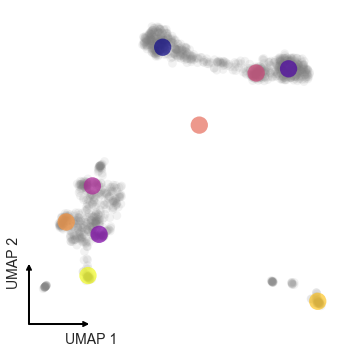

In [20]:
DR_plot(dim_name='UMAP', figsize=(5,5)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='X_umap')

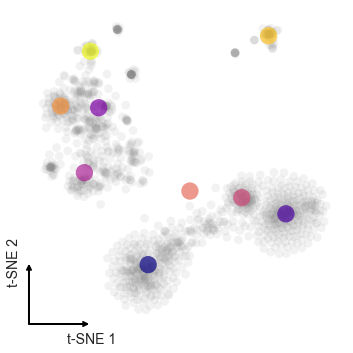

In [21]:
DR_plot(dim_name='t-SNE', figsize=(5,5)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='X_tsne')

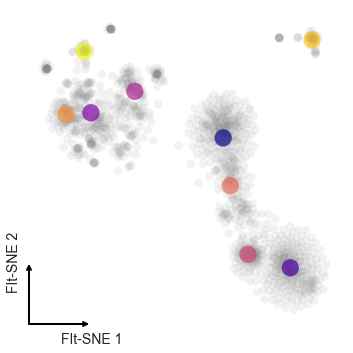

In [22]:
DR_plot(dim_name='FIt-SNE', figsize=(5,5)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='X_FItsne')

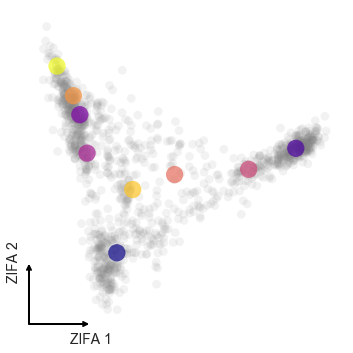

In [23]:
DR_plot(dim_name='ZIFA', figsize=(5,5)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='X_zifa')

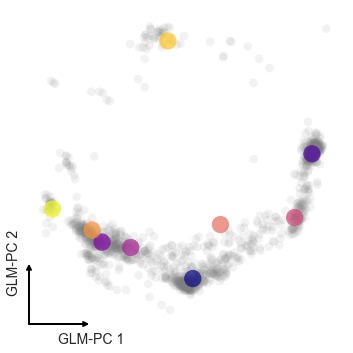

In [24]:
DR_plot(dim_name='GLM-PC', figsize=(5,5)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='X_GLM-PCA')

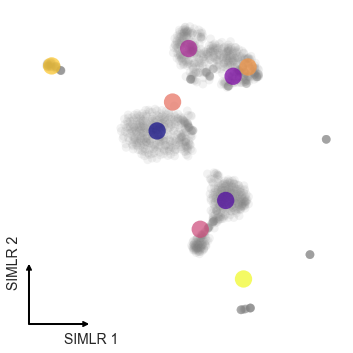

In [25]:
DR_plot(dim_name='SIMLR', figsize=(5,5)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='X_SIMLR')

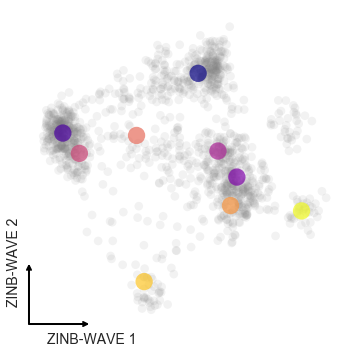

In [26]:
DR_plot(dim_name='ZINB-WAVE', figsize=(5,5)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='X_ZINBWAVE')

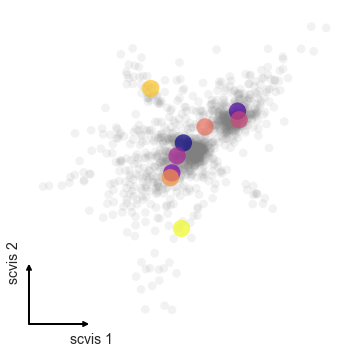

In [27]:
DR_plot(dim_name='scvis', figsize=(5,5)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='X_scvis')

In [65]:
ranks = [retina.uns['X_pca_centroid_ranks'],
         retina.uns['X_tsne_centroid_ranks'],
         retina.uns['X_umap_centroid_ranks'],
         retina.uns['X_dca_centroid_ranks'],
         retina.uns['X_FItsne_centroid_ranks'],
         retina.uns['X_zifa_centroid_ranks'],
         retina.uns['X_GLM-PCA_centroid_ranks'],
         retina.uns['X_SIMLR_centroid_ranks'],
         retina.uns['X_ZINBWAVE_centroid_ranks'],
         retina.uns['X_scvis_centroid_ranks'],
         retina.uns['X_scVI_centroid_ranks'],
        ]
df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True), ranks)

In [66]:
df_final.reset_index(inplace=True)

In [67]:
for col in df_final.columns:
    df_final[col] = df_final[col].astype(str) + '_' + col

In [68]:
df_final['count'] = retina.obs['cluster_fcc'].value_counts()

In [69]:
df_final

,index,X_pca,X_tsne,X_umap,X_dca,X_FItsne,X_zifa,X_GLM-PCA,X_SIMLR,X_ZINBWAVE,X_scvis,X_scVI,count
0,0.0_index,0_X_pca,0_X_tsne,0_X_umap,0_X_dca,0_X_FItsne,0_X_zifa,0_X_GLM-PCA,0_X_SIMLR,0_X_ZINBWAVE,0_X_scvis,0_X_scVI,309
1,1.0_index,7_X_pca,4_X_tsne,3_X_umap,5_X_dca,5_X_FItsne,6_X_zifa,7_X_GLM-PCA,4_X_SIMLR,6_X_ZINBWAVE,6_X_scvis,4_X_scVI,281
2,2.0_index,3_X_pca,5_X_tsne,5_X_umap,4_X_dca,6_X_FItsne,5_X_zifa,3_X_GLM-PCA,3_X_SIMLR,3_X_ZINBWAVE,3_X_scvis,3_X_scVI,258
3,3.0_index,2_X_pca,2_X_tsne,4_X_umap,3_X_dca,2_X_FItsne,3_X_zifa,2_X_GLM-PCA,2_X_SIMLR,1_X_ZINBWAVE,1_X_scvis,2_X_scVI,130
4,4.0_index,5_X_pca,3_X_tsne,2_X_umap,7_X_dca,3_X_FItsne,4_X_zifa,5_X_GLM-PCA,5_X_SIMLR,5_X_ZINBWAVE,5_X_scvis,6_X_scVI,94
5,5.0_index,1_X_pca,1_X_tsne,1_X_umap,2_X_dca,1_X_FItsne,2_X_zifa,1_X_GLM-PCA,1_X_SIMLR,2_X_ZINBWAVE,2_X_scvis,1_X_scVI,89
6,6.0_index,4_X_pca,6_X_tsne,6_X_umap,6_X_dca,8_X_FItsne,7_X_zifa,4_X_GLM-PCA,6_X_SIMLR,4_X_ZINBWAVE,4_X_scvis,5_X_scVI,77
7,7.0_index,8_X_pca,8_X_tsne,8_X_umap,1_X_dca,4_X_FItsne,1_X_zifa,8_X_GLM-PCA,7_X_SIMLR,8_X_ZINBWAVE,7_X_scvis,8_X_scVI,49
8,8.0_index,6_X_pca,7_X_tsne,7_X_umap,8_X_dca,7_X_FItsne,8_X_zifa,6_X_GLM-PCA,8_X_SIMLR,7_X_ZINBWAVE,8_X_scvis,7_X_scVI,39


In [96]:
tmp = df_final[['index','X_pca','X_tsne','count']]
flows = tmp.rename(columns={'index':'type','X_pca':'source','X_tsne':'target','count':'value'})

In [1]:
from floweaver import *

# Set the default size to fit the documentation better.
size = dict(width=570, height=300)

nodes = {
    'farms': ProcessGroup(['farm1', 'farm2', 'farm3',
                           'farm4', 'farm5', 'farm6']),
    'customers': ProcessGroup(['James', 'Mary', 'Fred', 'Susan']),
}

In [2]:
ordering = [
    ['farms'],       # put "farms" on the left...
    ['customers'],   # ... and "customers" on the right.
]

In [3]:
bundles = [
    Bundle('farms', 'customers'),
]

In [4]:
sdd = SankeyDefinition(nodes, bundles, ordering)
weave(sdd, flows).to_widget(**size)

NameError: name 'flows' is not defined

In [9]:
from ipysankeywidget import SankeyWidget

In [10]:
links = [
    {'source': 'start', 'target': 'A', 'value': 2},
    {'source': 'A', 'target': 'B', 'value': 2},
    {'source': 'C', 'target': 'A', 'value': 2},
    {'source': 'A', 'target': 'C', 'value': 2},
]

In [11]:
w = SankeyWidget(links=links, margins=dict(top=0, bottom=0, left=50, right=100))

In [12]:
w

SankeyWidget(links=[{'source': 'start', 'target': 'A', 'value': 2}, {'source': 'A', 'target': 'B', 'value': 2}…

In [5]:
%matplotlib inline

In [36]:
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

In [42]:
import plotly

In [43]:
fig = genSankey(df_final, cat_cols=['X_pca','X_tsne','X_umap'], value_cols='count', title='Ordinal Cluster Arrangement')
plotly.offline.plot(fig, validate=False)

'temp-plot.html'

In [ ]:
with plt.style.context('seaborn-white'):
    ax = pd.plotting.parallel_coordinates(df_final, class_column='index')
    plt.yticks(ticks=range(len(retina.obs['cluster_fcc'].unique())), labels=df_final['index'], fontsize='x-large')
    plt.xticks(fontsize='x-large', rotation='vertical')
    ax.legend().remove()
    ax.grid(False)
    plt.show()